# Projet Télédétection avancée
## Pyrénées 2023-2024
### TUIL Shona 

#### Bibliothèques et fonctions utilisées

In [2]:
import os
import sys
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from osgeo import gdal, ogr
gdal.UseExceptions()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib.colors import ListedColormap

# Import libsigma
sys.path.append("/home/onyxia/work/libsigma")
from classification import get_samples_from_roi
import plots

#### Chemins

In [3]:
# données en entrée 

data = "/home/onyxia/work/data/projet_eval"

# Rasters
raster_ref = os.path.join(data, "pyrenees_23-24_B03.tif")
b3 = os.path.join(data, "pyrenees_23-24_B03.tif")
b5 = os.path.join(data, "pyrenees_23-24_B05.tif")

# Échantillons
samples = os.path.join(data, "PI_strates_pyrenees_32630.shp")

# Chemins en sortie 
OUT_DIR = "results"
FIG_DIR = os.path.join(OUT_DIR, "figure")
os.makedirs(FIG_DIR, exist_ok=True)

raster_samples = os.path.join(OUT_DIR, "raster_samples.tif")
raster_ARI = os.path.join(OUT_DIR, "ARI_serie_temp.tif")
ARI_series = os.path.join(FIG_DIR, "ARI_series_temporelles.png")

In [4]:
champ_strate = "strate"
descr_strates = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}

dates = [
    "2023-09-25", "2023-09-30", "2023-10-05", "2023-10-07", "2023-10-10",
    "2023-10-12", "2023-11-19", "2023-12-16", "2024-01-25", "2024-03-13",
    "2024-04-12", "2024-05-09", "2024-06-13", "2024-07-23", "2024-08-22"
]

#### Analyse des échantillons

In [5]:
gdf_samples = gpd.read_file(samples)
samples_valid = gdf_samples[gdf_samples.geometry.notnull()].copy()

counts_poly = samples_valid[champ_strate].value_counts().sort_index()
df_poly = pd.DataFrame({
    "strate": counts_poly.index,
    "nb_polygones": counts_poly.values,
    "description": [descr_strates[i] for i in counts_poly.index]
})

Rasterisation et comptage des pixels

In [6]:
ref_ds = gdal.Open(raster_ref)
gt, proj = ref_ds.GetGeoTransform(), ref_ds.GetProjection()
cols, rows = ref_ds.RasterXSize, ref_ds.RasterYSize

driver = gdal.GetDriverByName("GTiff")
ds_roi = driver.Create(raster_samples, cols, rows, 1, gdal.GDT_Int32)
ds_roi.SetGeoTransform(gt)
ds_roi.SetProjection(proj)
band = ds_roi.GetRasterBand(1)
band.Fill(0)
band.SetNoDataValue(0)

vector_ds = ogr.Open(samples)
gdal.RasterizeLayer(ds_roi, [1], vector_ds.GetLayer(), options=[f"ATTRIBUTE={champ_strate}", "ALL_TOUCHED=TRUE"])
ds_roi = None

ds_strate = gdal.Open(raster_samples)
arr_strate = ds_strate.GetRasterBand(1).ReadAsArray()
ds_strate = None

strates_unique = np.unique(arr_strate[arr_strate != 0])
pixels_par_strate = {s: np.sum(arr_strate == s) for s in strates_unique}

df_pixels = pd.DataFrame({
    "strate": list(pixels_par_strate.keys()),
    "nb_pixels": list(pixels_par_strate.values()),
    "description": [descr_strates[i] for i in pixels_par_strate.keys()]
})

#### Diagrammes du nombre de polygones et du nombre de pixels par strates

In [7]:
# Définition de la palette (Gris, Vert Clair, Violet, Vert Foncé)
# Correspond aux strates : 1 (Sol Nu), 2 (Herbe), 3 (Landes), 4 (Arbre)
palette_couleurs = ["#A9A9A9", "#7CFC00", "#9370DB", "#006400"]

In [8]:
bar_width, facecolor_bg = 0.6, "#e0e0e0"
grid_color, grid_width = "#cccccc", 0.5
palette_couleurs = ["#555555", "#FFD700", "#FF00FF", "#006400"]

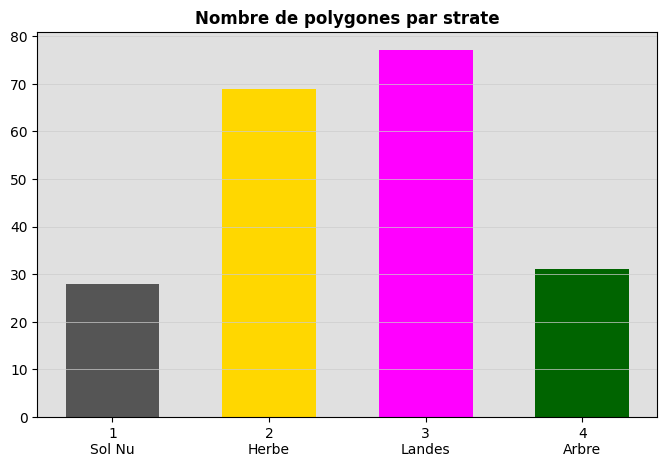

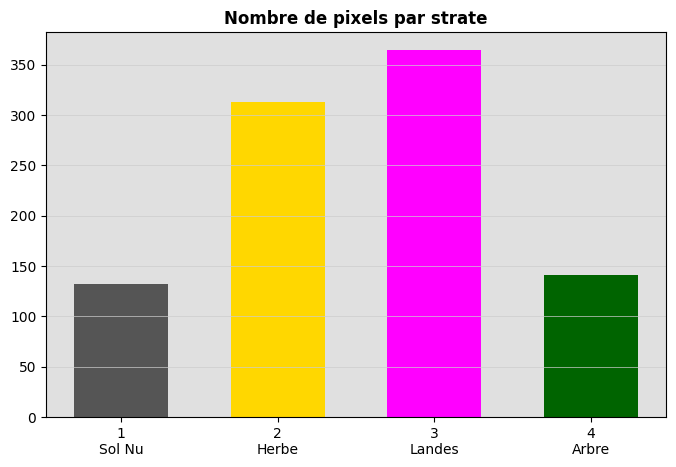

In [9]:
# --- Nb Polygones ---
fig, ax = plt.subplots(figsize=(8,5))
ax.set_facecolor(facecolor_bg)
ax.yaxis.grid(True, color=grid_color, linewidth=grid_width)

# On passe la liste de couleurs à l'argument 'color'
ax.bar(df_poly["strate"], df_poly["nb_polygones"], color=palette_couleurs, width=bar_width)

ax.set_title("Nombre de polygones par strate", fontweight='bold')
ax.set_xticks(df_poly["strate"])
ax.set_xticklabels([f"{i}\n{descr_strates[i]}" for i in df_poly["strate"]])
plt.savefig(os.path.join(FIG_DIR, "diag_baton_nb_poly_by_class.png"))

# --- Nb Pixels ---
fig, ax = plt.subplots(figsize=(8,5))
ax.set_facecolor(facecolor_bg)
ax.yaxis.grid(True, color=grid_color, linewidth=grid_width)

# Application de la même palette pour les pixels
ax.bar(df_pixels["strate"], df_pixels["nb_pixels"], color=palette_couleurs, width=bar_width)

ax.set_title("Nombre de pixels par strate", fontweight='bold')
ax.set_xticks(df_pixels["strate"])
ax.set_xticklabels([f"{i}\n{descr_strates[i]}" for i in df_pixels["strate"]])
plt.savefig(os.path.join(FIG_DIR, "diag_baton_nb_pix_by_class.png"))

plt.show()

### Phénologie des strates, mise en évidence des landes

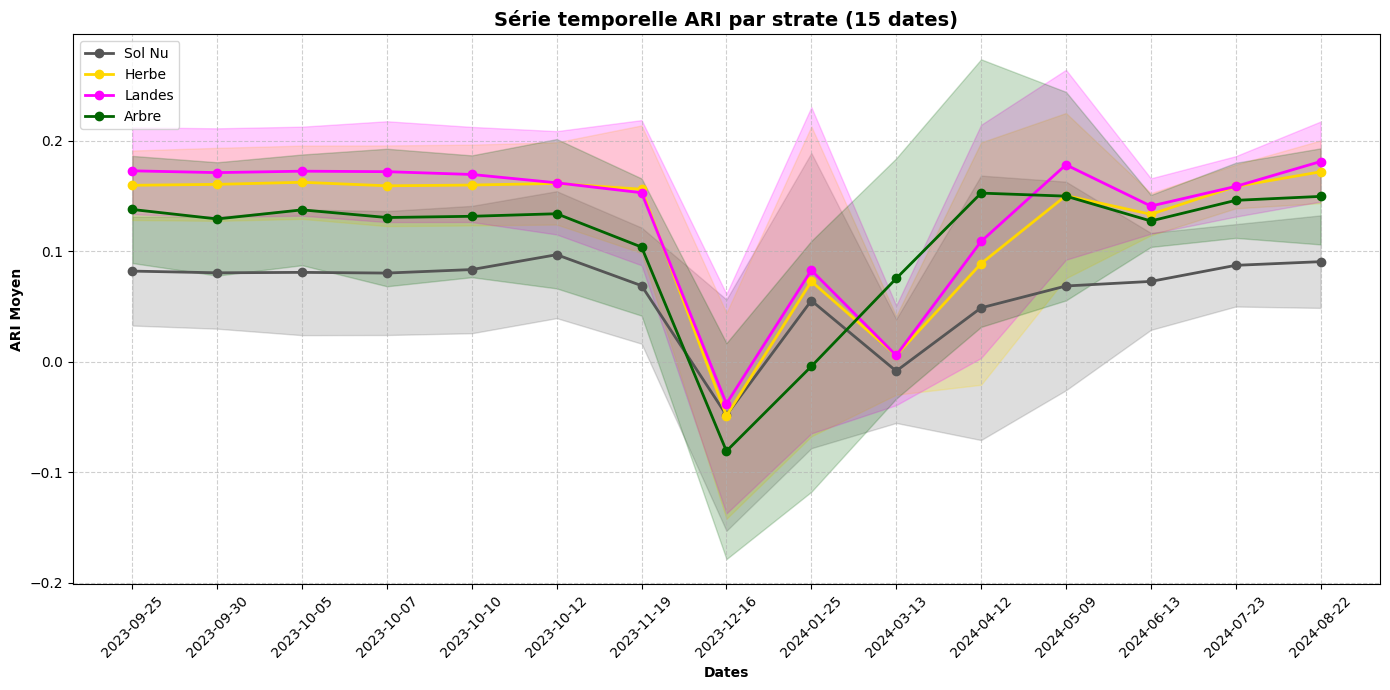

In [10]:
ds_b3 = gdal.Open(b3)
ds_b5 = gdal.Open(b5)
nb_bands = ds_b3.RasterCount

b3_cube = ds_b3.ReadAsArray().astype(np.float32)
b5_cube = ds_b5.ReadAsArray().astype(np.float32)

with np.errstate(divide='ignore', invalid='ignore'):
    inv_b3 = 1 / b3_cube
    inv_b5 = 1 / b5_cube
    ARI_cube = (inv_b3 - inv_b5) / (inv_b3 + inv_b5)

ARI_cube[np.isnan(ARI_cube)] = -9999

# Sauvegarde Raster ARI
ds_ari = driver.Create(raster_ARI, cols, rows, nb_bands, gdal.GDT_Float32)
ds_ari.SetGeoTransform(gt); ds_ari.SetProjection(proj)
for i in range(nb_bands):
    band_ari = ds_ari.GetRasterBand(i+1)
    band_ari.WriteArray(ARI_cube[i])
    band_ari.SetNoDataValue(-9999)
ds_ari = None

# Graphique ARI par strate
fig, ax = plt.subplots(figsize=(14, 7))

for c, label in descr_strates.items():
    mask = (arr_strate == c)
    if not np.any(mask): continue
    
    # On utilise directement la variable définie plus haut
    couleur_strate = palette_couleurs[c-1]
    
    ARI_flat = ARI_cube.reshape(nb_bands, -1)
    masked_data = ARI_flat[:, mask.flatten()]
    masked_data = np.where(masked_data == -9999, np.nan, masked_data)
    
    mean_values = np.nanmean(masked_data, axis=1)
    std_values = np.nanstd(masked_data, axis=1)

    # Application de la couleur
    ax.plot(dates, mean_values, label=label, marker='o', linewidth=2, color=couleur_strate)
    ax.fill_between(dates, mean_values - std_values, mean_values + std_values, 
                    alpha=0.2, color=couleur_strate)

ax.set_xlabel("Dates", fontweight='bold')
ax.set_ylabel("ARI Moyen", fontweight='bold')
ax.set_title("Série temporelle ARI par strate (15 dates)", fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
ax.legend(loc='upper left', frameon=True)
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(ARI_series, dpi=300)
plt.show()


#### Classification RF

In [11]:
bandes_s2 = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
fichiers_physiques = []
feature_names_full = []

# Utilisation de dates pour construire les noms des 165 variables

for b in bandes_s2:
    path = os.path.join(data, f"pyrenees_23-24_{b}.tif")
    if os.path.exists(path):
        fichiers_physiques.append(path)
        for d in dates:
            feature_names_full.append(f"{b}_{d}")

In [12]:
if os.path.exists(raster_ARI):
    fichiers_physiques.append(raster_ARI)
    for d in dates:
        feature_names_full.append(f"ARI_{d}")

vrt_stack = os.path.join(OUT_DIR, "stack_temp.vrt")
gdal.BuildVRT(vrt_stack, fichiers_physiques, separate=True)

print(f"Extraction des échantillons (165 variables)...")
X, Y, t = get_samples_from_roi(vrt_stack, raster_samples)
Y = Y.ravel()

Extraction des échantillons (165 variables)...


In [13]:
# Groupe ID pour validation croisée (évite l'overfitting spatial)
ds_id = driver.Create("/vsimem/ids.tif", cols, rows, 1, gdal.GDT_Int32)
ds_id.SetGeoTransform(gt); ds_id.SetProjection(proj)
gdal.RasterizeLayer(ds_id, [1], vector_ds.GetLayer(), options=["ATTRIBUTE=id"])
groups = ds_id.ReadAsArray()[t].ravel()

X = np.nan_to_num(X, nan=0.0)
X[X == -9999] = 0

In [14]:
## GRILLE D'OPTIMISATION (CONSIGNE PROF) ---
print("Optimisation GridSearchCV (Grille complète)...")
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 5]
}

cv = StratifiedGroupKFold(n_splits=3)
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=1), 
    param_grid, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1
)

Optimisation GridSearchCV (Grille complète)...


In [15]:
grid_search.fit(X, Y, groups=groups)
best_rf = grid_search.best_estimator_

In [16]:
# Évaluation par validation croisée
y_pred = cross_val_predict(best_rf, X, Y, groups=groups, cv=cv)

print(f"\nMEILLEURS PARAMÈTRES : {grid_search.best_params_}")
print(f"SCORE GLOBAL FINAL (OA) : {accuracy_score(Y, y_pred):.2f}")
print(classification_report(Y, y_pred, target_names=[descr_strates[i] for i in np.unique(Y)]))


MEILLEURS PARAMÈTRES : {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 50}
SCORE GLOBAL FINAL (OA) : 0.85
              precision    recall  f1-score   support

      Sol Nu       0.96      0.82      0.88       132
       Herbe       0.80      0.90      0.85       313
      Landes       0.84      0.84      0.84       364
       Arbre       0.93      0.79      0.85       141

    accuracy                           0.85       950
   macro avg       0.88      0.84      0.85       950
weighted avg       0.85      0.85      0.85       950



Analyse de la grille de recherche (Grid Search) : L'analyse des résultats de l'optimisation montre que le modèle est particulièrement sensible à la méthode de sélection des variables (max_features). Les performances maximales (Exactitude Globale de 0,93) sont systématiquement obtenues avec le réglage log2. En revanche, on observe une grande stabilité (un plateau de performance) concernant la profondeur des arbres (max_depth) dès lors qu'elle dépasse 10.

Choix de représentation : Pour la heatmap, nous avons choisi de représenter le croisement entre le nombre d'arbres (n_estimators) et la profondeur maximale (max_depth), en fixant les autres paramètres sur leurs valeurs optimales (max_features='log2' et min_samples_leaf=1).

Justification scientifique :

Équilibre Complexité/Stabilité : Ce couple de paramètres est le plus révélateur de la structure du modèle Random Forest. Il permet de visualiser si le modèle a besoin d'arbres profonds (complexité) pour discriminer les strates ou si une forêt dense (stabilité) suffit.

Mise en évidence du plateau : La heatmap permet de prouver visuellement qu'au-delà d'un certain seuil, augmenter la complexité du modèle n'apporte plus de gain de précision, validant ainsi la robustesse de nos 165 variables spectrales.

Optimisation des ressources : Cette visualisation justifie le choix final des paramètres en montrant la zone de "chaleur" (scores les plus hauts) où le compromis entre temps de calcul et précision est optimal.

In [20]:
import pandas as pd

# 1. On récupère les résultats
results_df = pd.DataFrame(grid_search.cv_results_)

# 2. Sélection et renommage des colonnes pour la lisibilité
cols_utiles = {
    'rank_test_score': 'Rang',
    'mean_test_score': 'Accuracy Moyenne',
    'param_n_estimators': 'Arbres',
    'param_max_depth': 'Profondeur',
    'param_max_features': 'Features',
    'param_min_samples_leaf': 'Min Feuilles',
    'mean_fit_time': 'Temps calcul (s)'
}

# 3. Création du tableau de synthèse
top_10_df = results_df[list(cols_utiles.keys())].sort_values(by='rank_test_score').head(10)
top_10_df = top_10_df.rename(columns=cols_utiles)

# Affichage
print("### TOP 10 DES COMBINAISONS D'HYPERPARAMÈTRES ###")
display(top_10_df.style.hide(axis='index').background_gradient(cmap='Greens', subset=['Accuracy Moyenne']))

### TOP 10 DES COMBINAISONS D'HYPERPARAMÈTRES ###


Rang,Accuracy Moyenne,Arbres,Profondeur,Features,Min Feuilles,Temps calcul (s)
1,0.929743,50,None,log2,1,0.219481
1,0.929743,50,10,log2,1,0.277811
1,0.929743,50,20,log2,1,0.246107
1,0.929743,50,15,log2,1,0.219360
5,0.928393,100,15,log2,1,0.430577
5,0.928393,100,20,log2,1,0.572839
5,0.928393,100,None,log2,1,0.440011
8,0.927943,100,None,sqrt,1,0.670910
8,0.927943,100,10,log2,1,0.440690
8,0.927943,100,15,sqrt,1,0.655851


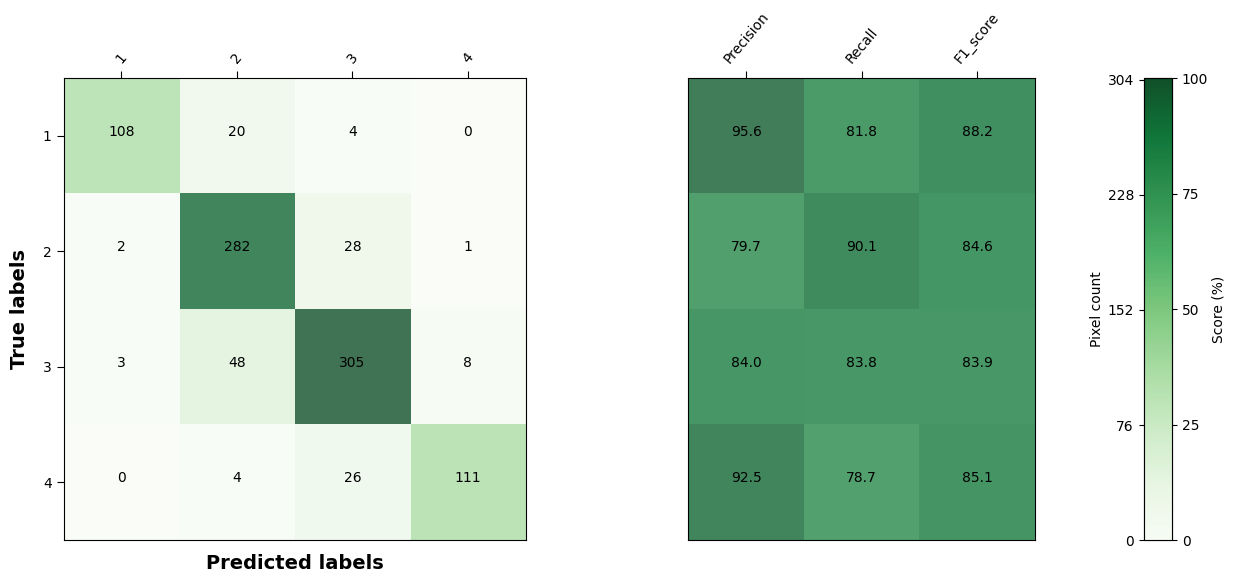

In [21]:
# ==============================================================================
# 7 --- VISUALISATION : MATRICE
# ==============================================================================

# Matrice de confusion
cm = confusion_matrix(Y, y_pred, labels=np.unique(Y))
plots.plot_cm(cm, np.unique(Y))
plt.savefig(os.path.join(FIG_DIR, "matrice_confusion_finale.png"))
plt.show()

In [ ]:
import pandas as pd

# 1. Conversion des résultats en DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Liste des paramètres testés
params_to_analyze = ['param_n_estimators', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf']

print("\n--- ANALYSE INDIVIDUELLE DES HYPERPARAMÈTRES ---")

for param in params_to_analyze:
    print(f"\nInfluence de : {param}")
    
    # On groupe par le paramètre en question et on calcule la moyenne et l'écart-type
    # (L'écart-type permet de voir si le paramètre rend le modèle instable)
    stats = results_df.groupby(param)['mean_test_score'].agg(['mean', 'std', 'max']).sort_values(by='mean', ascending=False)
    
    # Renommer pour plus de clarté
    stats.columns = ['Score Moyen', 'Écart-type', 'Score Max']
    
    print(stats)

NameError: name 'grid_search' is not defined

Importance des variables 

Génération du graphique d'importance détaillée (165 variables)...


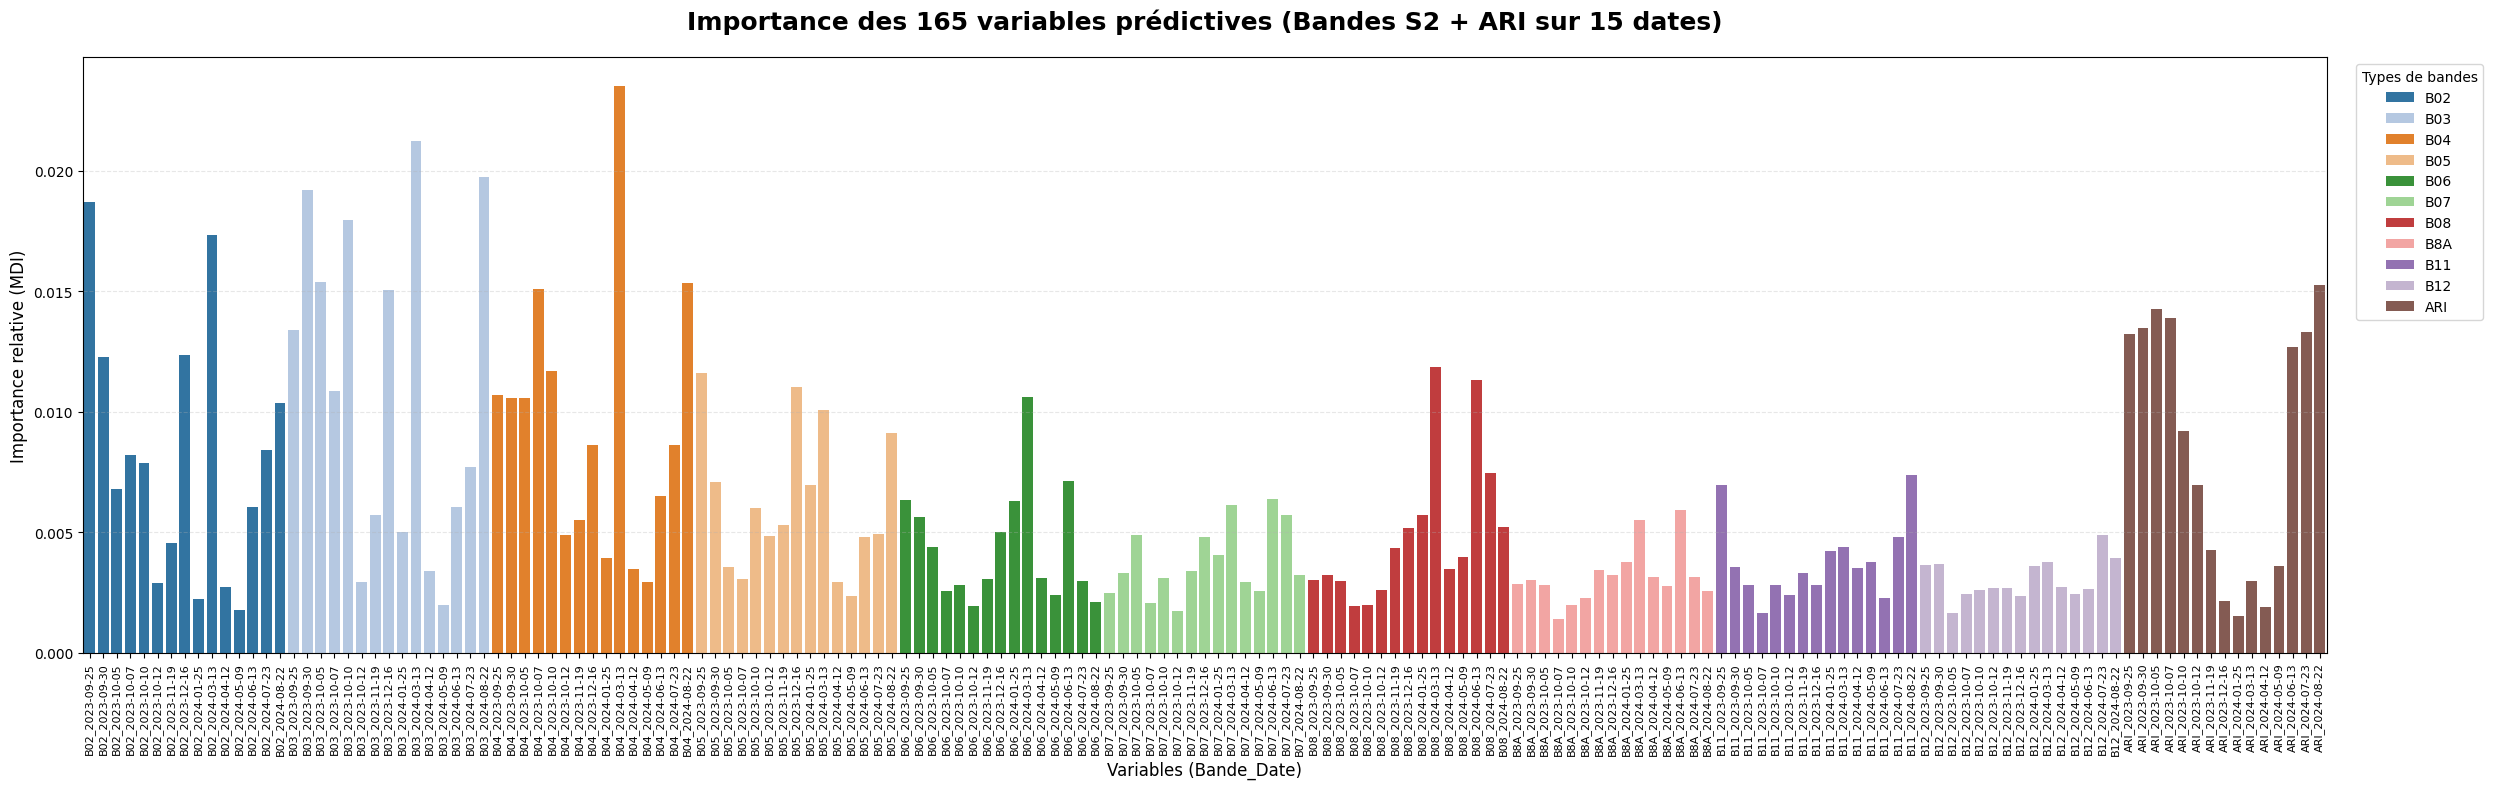

Graphique détaillé sauvegardé dans : results/figure/importance_165_variables_detail.png


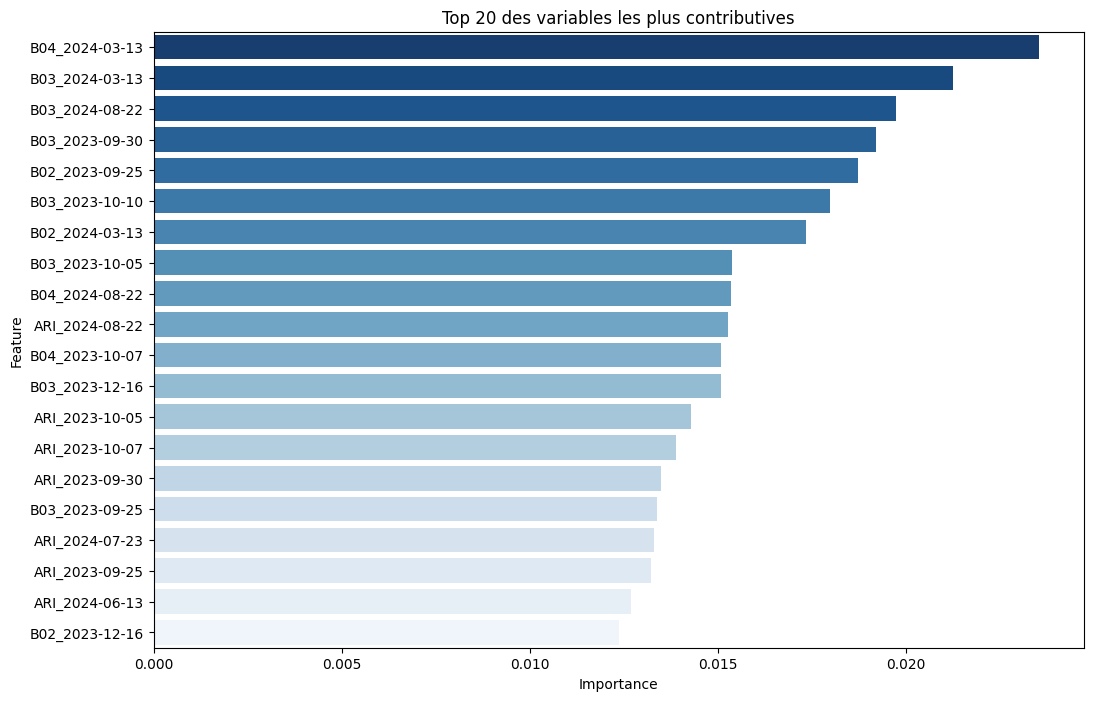

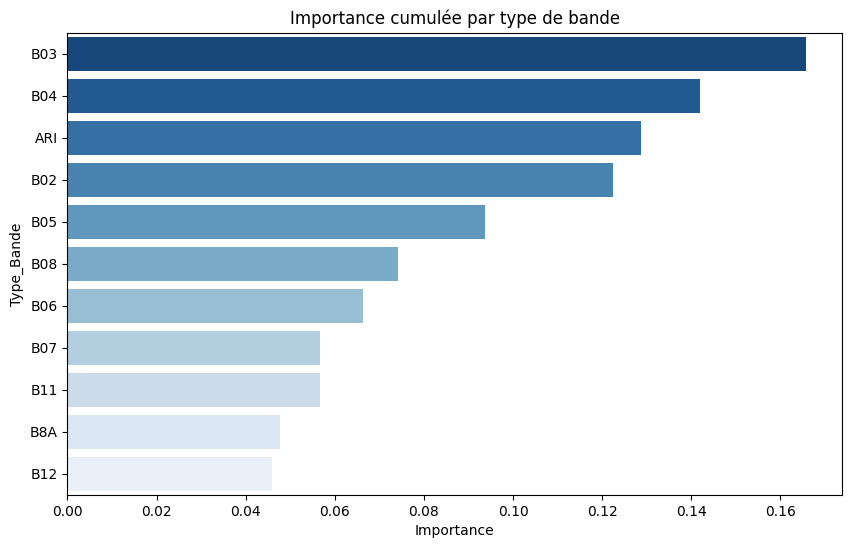

In [ ]:

print("Génération du graphique d'importance détaillée (165 variables)...")

# 1. Création du DataFrame d'importance
df_detail = pd.DataFrame({
    'Variable': feature_names_full, 
    'Importance': best_rf.feature_importances_
})

# On ajoute le type de bande pour la coloration
df_detail['Type_Bande'] = df_detail['Variable'].apply(lambda x: x.split('_')[0])

# 2. Configuration du graphique (très large pour que ce soit lisible)
plt.figure(figsize=(25, 8), facecolor='white')

# On trace toutes les barres. 'hue' permet de colorer par type de bande automatiquement
sns.barplot(x='Variable', y='Importance', data=df_detail, 
            hue='Type_Bande', palette='tab20', dodge=False)

# 3. Cosmétique et lisibilité
plt.title(f"Importance des 165 variables prédictives (Bandes S2 + ARI sur 15 dates)", 
          fontsize=18, fontweight='bold', pad=20)
plt.ylabel("Importance relative (MDI)", fontsize=12)
plt.xlabel("Variables (Bande_Date)", fontsize=12)

# Rotation des étiquettes à 90 degrés pour qu'elles ne se chevauchent pas
plt.xticks(rotation=90, fontsize=8)

# Légende à l'extérieur pour ne pas cacher les barres
plt.legend(title="Types de bandes", bbox_to_anchor=(1.01, 1), loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

# Sauvegarde en haute définition
plt.savefig(os.path.join(FIG_DIR, "importance_165_variables_detail.png"), dpi=300, bbox_inches='tight')
plt.show()

print("Graphique détaillé sauvegardé dans : results/figure/importance_165_variables_detail.png")



# Top 20 variables

df_all_imp = pd.DataFrame({'Feature': feature_names_full, 'Importance': best_rf.feature_importances_})

df_top20 = df_all_imp.sort_values(by='Importance', ascending=False).head(20)



plt.figure(figsize=(12, 8))

sns.barplot(x='Importance', y='Feature', data=df_top20, palette='Blues_r', hue='Feature', legend=False)

plt.title("Top 20 des variables les plus contributives")

plt.savefig(os.path.join(FIG_DIR, "importance_top20_final.png"))

plt.show()


# Synthèse par bande
df_all_imp['Type_Bande'] = df_all_imp['Feature'].apply(lambda x: x.split('_')[0])
df_synth = df_all_imp.groupby('Type_Bande')['Importance'].sum().reset_index().sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Type_Bande', data=df_synth, palette='Blues_r', hue='Type_Bande', legend=False)
plt.title("Importance cumulée par type de bande")
plt.savefig(os.path.join(FIG_DIR, "importance_synthetique_bandes.png"))
plt.show()

#### Production et affichage de la carte

/home/onyxia/work/libsigma/classification.py:101: RuntimeWarning: invalid value encountered in cast
  Y = ROI[t].reshape((t[0].shape[0], 1)).astype('int32')


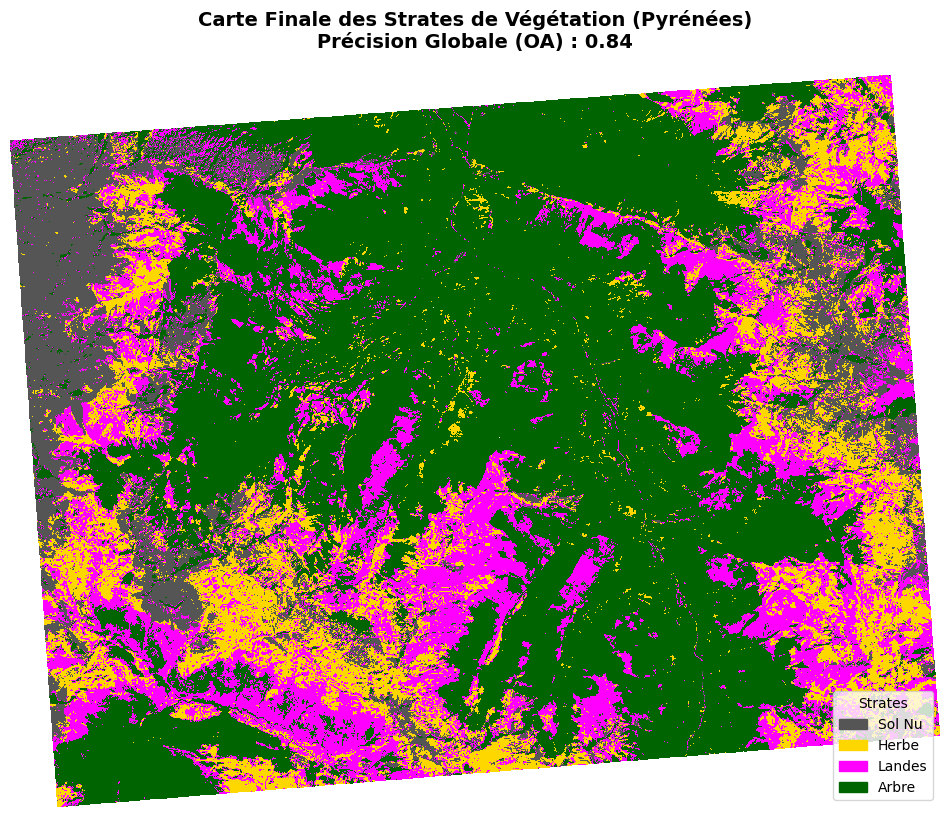

TERMINÉ ! Carte enregistrée sous : results/carte_strates_finale_pro.tif


In [ ]:
# 1. On ré-entraîne une dernière fois
best_rf.fit(X, Y)

# 2. Prédiction sur l'image complète
X_all, _, t_all = get_samples_from_roi(vrt_stack, vrt_stack)
X_all = np.nan_to_num(X_all, nan=0.0)
predictions = best_rf.predict(X_all)

# 3. Reconstruction de la carte en 2D
carte_raw = np.zeros((rows, cols), dtype=np.uint8)
carte_raw[t_all[0], t_all[1]] = predictions

# 4. Masque d'emprise
ds_ref_for_mask = gdal.Open(raster_ref)
arr_ref_mask = ds_ref_for_mask.GetRasterBand(1).ReadAsArray()
ds_ref_for_mask = None 
carte_final_clean = np.where(arr_ref_mask > 0, carte_raw, 0)

# 5. Rendu visuel avec TA PALETTE
map_masked = np.ma.masked_where(carte_final_clean == 0, carte_final_clean)

plt.figure(figsize=(12, 10), facecolor='white')

# On utilise ici ta variable palette_couleurs définie au début du script
custom_cmap = ListedColormap(palette_couleurs)
custom_cmap.set_bad(color='white') 

im = plt.imshow(map_masked, cmap=custom_cmap, vmin=1, vmax=4, interpolation='none')

# --- OPTION : Une légende avec des carrés (plus pro qu'une colorbar) ---
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=palette_couleurs[i], label=descr_strates[i+1]) for i in range(len(palette_couleurs))]
plt.legend(handles=patches, loc='lower right', title="Strates", frameon=True, fontsize=10)

plt.title(f"Carte Finale des Strates de Végétation (Pyrénées)\nPrécision Globale (OA) : {accuracy_score(Y, y_pred):.2f}", 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('off')

plt.savefig(os.path.join(FIG_DIR, 'carte_finale_style_lisa.png'), dpi=300, bbox_inches='tight')
plt.show()

# 6. Sauvegarde du fichier TIF final
out_path_tif = os.path.join(OUT_DIR, "carte_strates_finale_pro.tif")
ds_final = driver.Create(out_path_tif, cols, rows, 1, gdal.GDT_Byte)
ds_final.SetGeoTransform(gt); ds_final.SetProjection(proj)
ds_final.GetRasterBand(1).WriteArray(carte_final_clean)
ds_final.GetRasterBand(1).SetNoDataValue(0)
ds_final = None

print(f"TERMINÉ ! Carte enregistrée sous : {out_path_tif}")